# Supervisor controllers

This notebook shows the behavior of several controller options in `Supervisor`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pprint

from electrolyzer import Supervisor, run_electrolyzer
from electrolyzer.inputs.validation import load_modeling_yaml

Text(0, 0.5, 'Power (MW)')

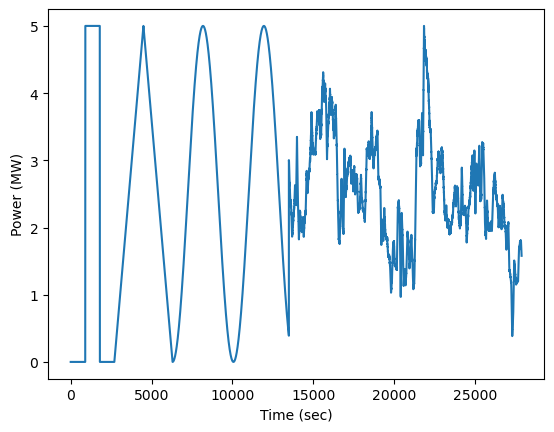

In [2]:
# Generate a power signal to illustrate Supervisor behavior

dt = 1

p1 = np.zeros(15*60)                                    # 15 minute buffer
p2 = np.ones(15*60)                                     # step up 30 minutes
p3 = np.zeros(15*60)                                    # step down 30 minutes
p4 = np.linspace(0, 1, 30*60)                           # ramp up 1 hour
p5 = np.linspace(1, 0, 30*60)                           # ramp down 1 hour

t_sin = np.logspace(0, np.log10(2*3600), 2*3600) - 1
t_sin = np.linspace(0, 2*3600, 2*3600)
p6 = 0.5*(np.sin(t_sin/600 - np.pi/2)+1)                # sine wave 2 hours

ws = np.load(Path.cwd() / 'FC_wind' / 'FC_August_1sec_1day.npy')[0:4*3600]
ws = ws/max(ws)
p7 = ws                                                 # wind 4 hours

plant_rating = 5e6                                      # 5 MW H2 plant

power = plant_rating*np.concatenate([p1, p2, p3, p4, p5, p6, p7])

plt.plot(power*1e-6)
plt.xlabel('Time (sec)')
plt.ylabel('Power (MW)')

In [3]:
def plot_results(result_df):

    # Collect H2 production rate timeseries from results
    stack_rates = result_df[[col for col in result_df.columns if "_kg_rate" in col]]

    fig_H2, ax_H2 = plt.subplots(6, 1, figsize=(10, 5), sharex=True)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']

    ax_H2[0].plot(power*1e-6, color='k', label='power (MW)')
    ax_H2[0].legend(loc='lower right')
    for i, stack in enumerate(stack_rates.columns):
        ax_H2[i+1].plot(stack_rates[stack], color=colors[i], label=stack)
        ax_H2[i+1].legend(loc='lower right')
    fig_H2.subplots_adjust(hspace=0)

    # Collect degradation timeseries from results
    deg = result_df[[col for col in result_df.columns if "deg" in col]]
    
    fig_deg, ax_deg = plt.subplots(6, 1, figsize=(10, 5), sharex=True)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']

    ax_deg[0].plot(power*1e-6, color='k', label='power (MW)')
    ax_deg[0].legend(loc='lower right')
    for i, stack in enumerate(deg.columns):
        ax_deg[i+1].plot(deg[stack], color=colors[i], label=stack)
        ax_deg[i+1].legend(loc='lower right')
    fig_deg.subplots_adjust(hspace=0)
    

## Decision control - baseline

Turn all stacks on and off simultaneously and give them all the same power input.

In [4]:
fname_input_modeling = "./modeling_options.yaml"
modeling_input = load_modeling_yaml(fname_input_modeling)
pprint.pprint(modeling_input)

{'electrolyzer': {'cell_params': {'ALK_params': {'electrode': {'A_electrode': 300,
                                                               'd_ac': 0.25,
                                                               'd_am': 0.125,
                                                               'd_cm': 0.125,
                                                               'e_a': 0.2,
                                                               'e_c': 0.2},
                                                 'electrolyte': {'w_koh': 30},
                                                 'membrane': {'A_membrane': 300,
                                                              'e_m': 0.05},
                                                 'model': 'default_hri',
                                                 'pressure_operating': 1,
                                                 'turndown_ratio': 0.25},
                                  'PEM_params': {'cell_area': 1000,
        

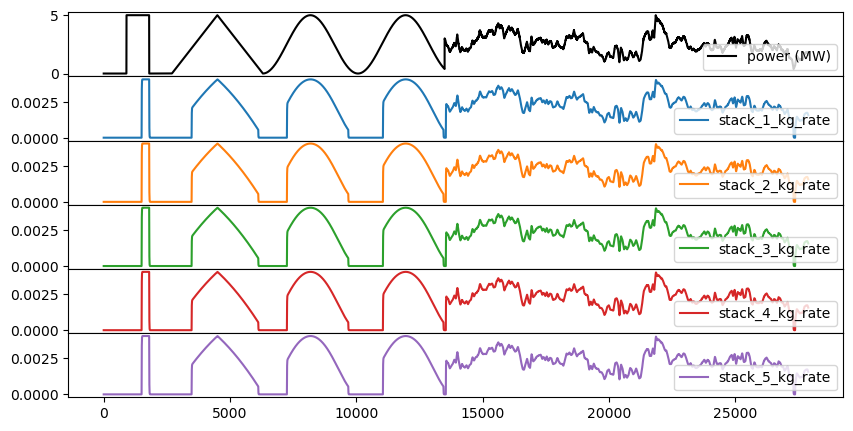

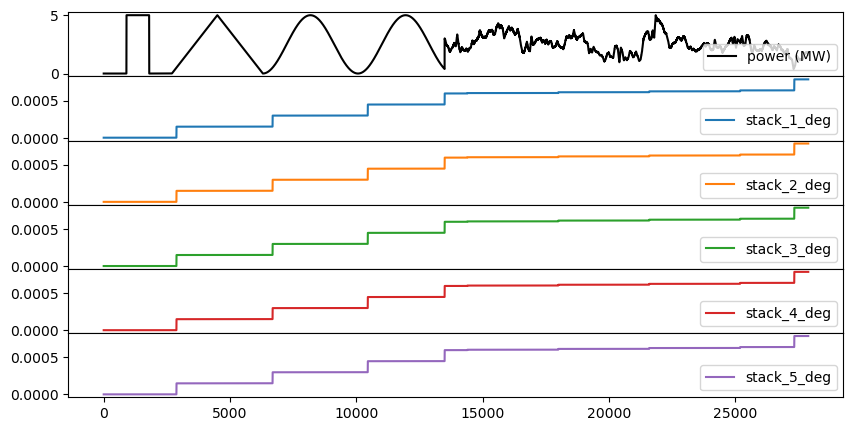

In [5]:
elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)

# BaslineDeg

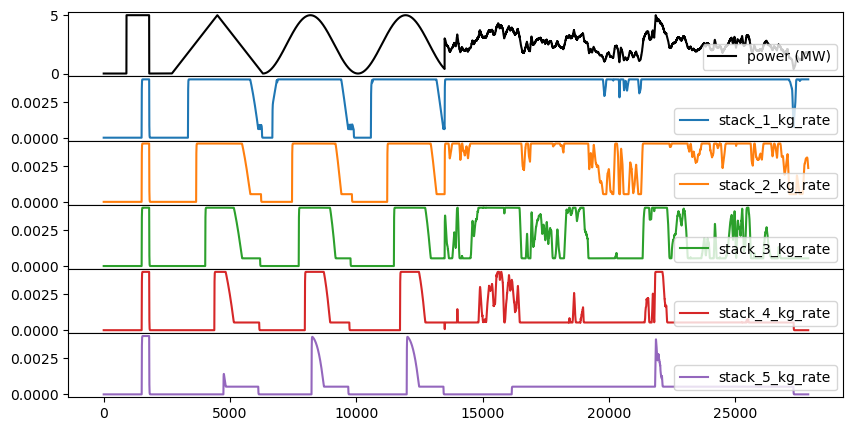

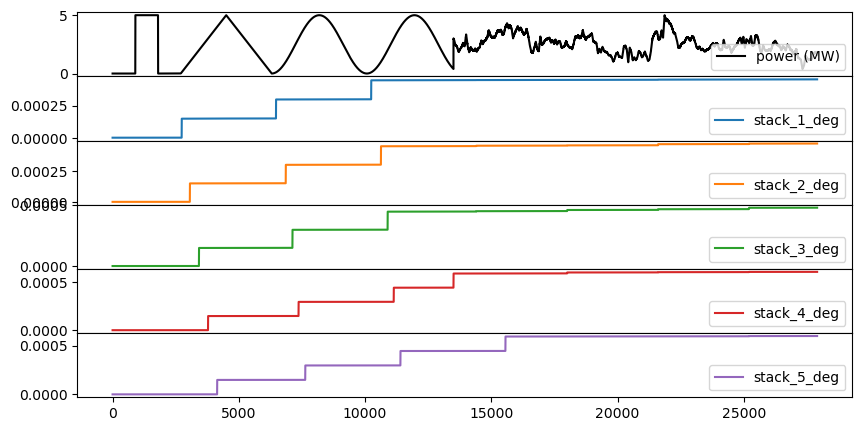

In [11]:
modeling_input['electrolyzer']['controller']['control_type'] = "BaselineDeg"

elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)

## Power sharing rotation

Distribute power evenly amongst the active stacks and switch them on and off in a preset order

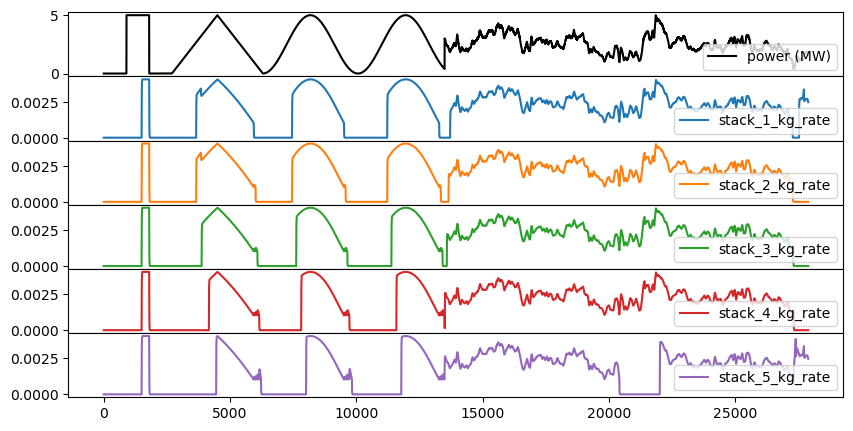

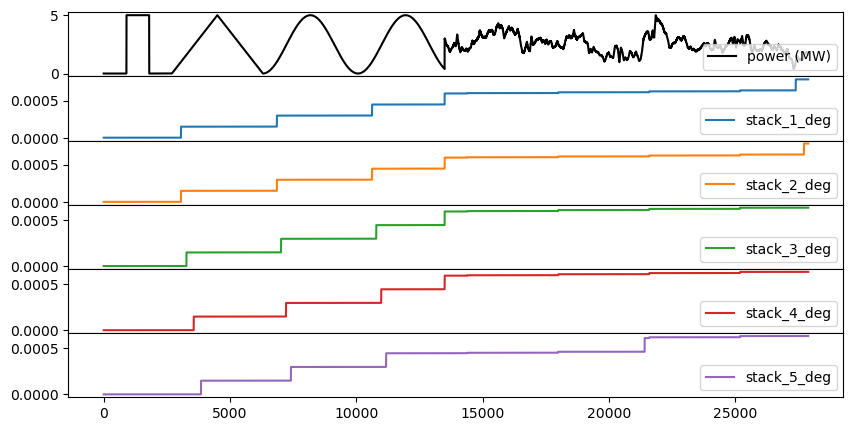

In [6]:
modeling_input['electrolyzer']['controller']['control_type'] = "PowerSharingRotation"

elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)

## Sequential rotation

Distribute power sequentially amongst the active stacks; stack 1 must be given full power before stack 2 gets any power. Switch them on and off in a preset order.

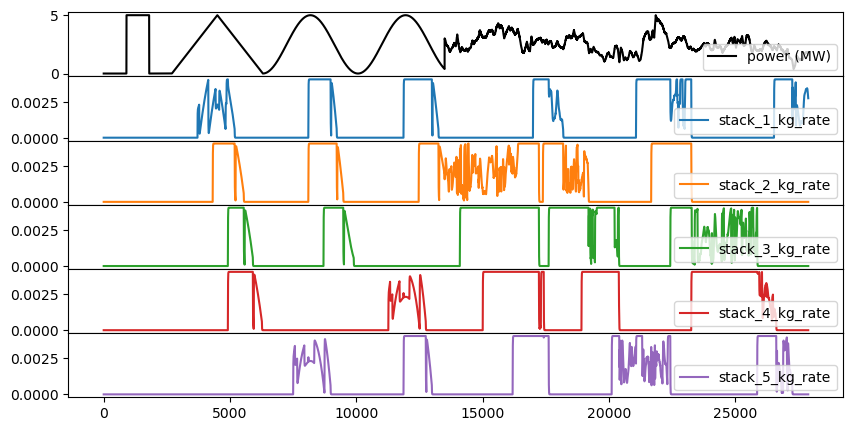

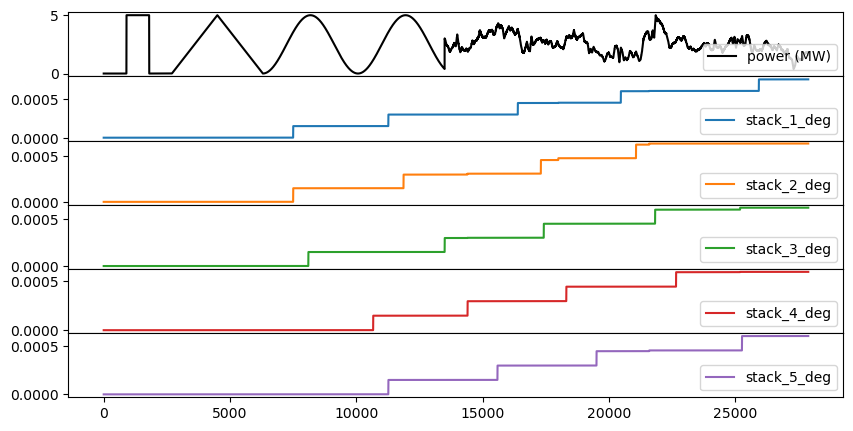

In [7]:
modeling_input['electrolyzer']['controller']['control_type'] = "SequentialRotation"

elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)

## Decision control - eager on, hesitant off, sequential switching order, even power distribution

Switch on inactive stacks as soon as there is enough power to do so and switch off active stacks only when there is no other option. Distribute power evenly amongst active stacks and switch them on and off in a preset order. 

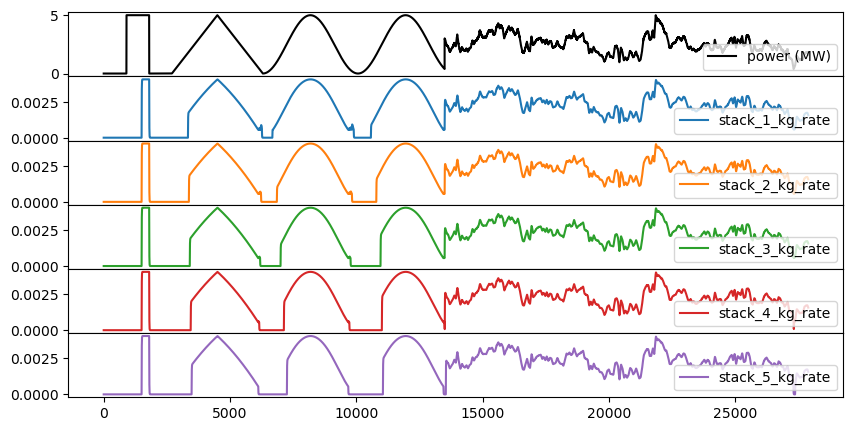

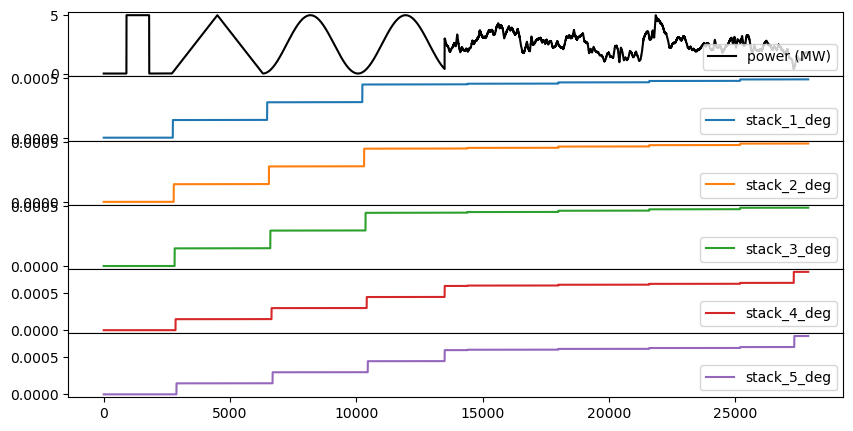

In [8]:
modeling_input['electrolyzer']['controller']['control_type'] = "DecisionControl"
modeling_input['electrolyzer']['controller']['policy'] = {
    'eager_on':     True,
    'eager_off':    False,
    'sequential':   True,
    'even_dist':    True,
    'baseline':     False
}

elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)

## Decision control - hesitant on, eager off, degradation-based switching order, variable power distribution

Only switch inactive stacks on when the currently active stacks can no longer consume all of the available power, switch active stacks off as soon as the available power can be fully consumed by fewer stacks. Switch the least-degraded inactive stack on and switch the most-degraded active stack off. Distribute power sequentially filling up the first stack with power before the next stack gets any power. 

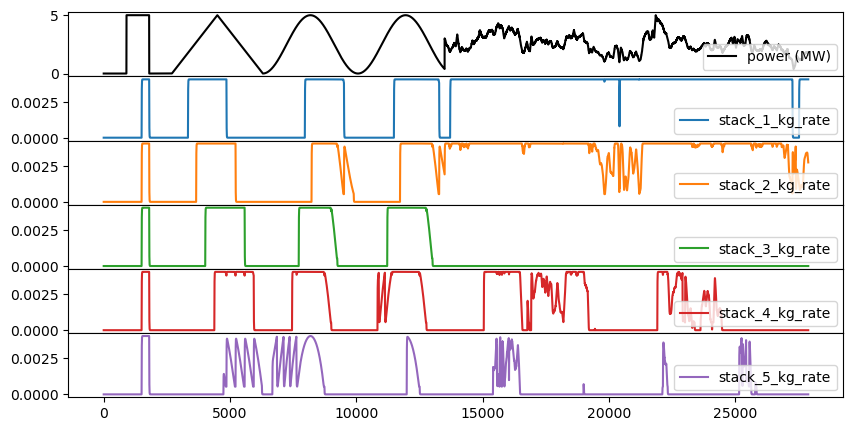

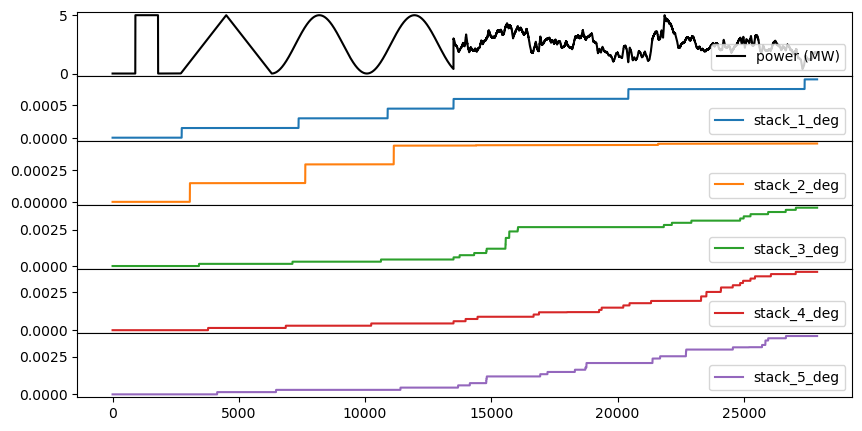

In [9]:
modeling_input['electrolyzer']['controller']['control_type'] = "DecisionControl"
modeling_input['electrolyzer']['controller']['policy'] = {
    'eager_on':     False,
    'eager_off':    True,
    'sequential':   False,
    'even_dist':    False,
    'baseline':     False
}

elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)

## Decision control - hesitant on, hesitant off, sequential switching order, variable power distribution

Only switch inactive stacks on when the currently active stacks can no longer consume all of the available power, switch active stacks off only when there is not enough power to support them all. Switch stacks on and off according to a preset order. Distribute power sequentially filling up the first stack with power before the next stack gets any power. 


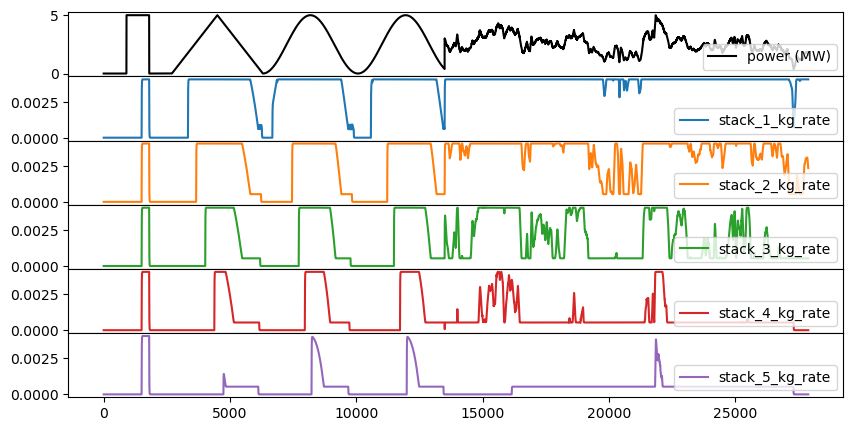

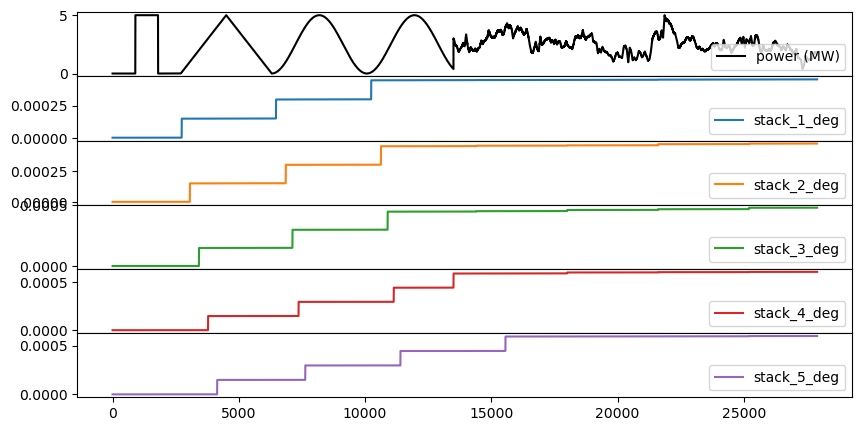

In [10]:
modeling_input['electrolyzer']['controller']['control_type'] = "DecisionControl"
modeling_input['electrolyzer']['controller']['policy'] = {
    'eager_on':     False,
    'eager_off':    False,
    'sequential':   True,
    'even_dist':    False,
    'baseline':     False
}

elec_sys, result_df = run_electrolyzer(modeling_input, power)
plot_results(result_df)